In [ ]:
# If you have already installed the `audience_modeling_toolbox` comment these two line:
!git clone https://github.com/OpenMeasurement/audience_modeling_toolbox/ 
!pip install "./audience_modeling_toolbox"

In [1]:
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter, uniform_filter
import itertools

# Plotting
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Importing the package
import audience_modeling_toolbox
from audience_modeling_toolbox.model import MixtureOfExponentials
from audience_modeling_toolbox.report import RFReport, generate_report

%matplotlib inline

# Synthesizing the impression logs

In the next we steps, we generate a random society and simulate a random advertising campaign in order to use that data for the virtual society modeling later in the notebook.

## Generate a random society

We start by Synthesizing a society of `population_size = 10000` indivituals with two media that they can get exposed to advertising on, which we call them `MEDIUM I` and `MEDIUM II`. This is done by choosing a random activity distribution function or ADF. For the example below we choose either a mixture of exponentials or power law functions based on our expectation of what the society should look like. Note that if the behavior of the society is known we can utilize that instead of choosing at random. Anyways, here we are just feeling lucky, so let us make our random society by randomly generating a society of users that follow our random ADF!

You should see the society table generated as a Pandas dataframe with a column called `user_id` and two columns corresponding to the random activity user in each medium. Therefore, the numbers in from of each user indicates how active each user is on `MEDIUM I` and `MEDIUM II` respectively.

In [2]:
# Generation of a random society for two media, "MEDIUM I" and "MEDIUM II"
population_size = 10000
media = ['MEDIUM I', 'MEDIUM II']

# Random activity distribution function
adf = MixtureOfExponentials.random(n_exps=6, n_dims=2, rng=np.random.default_rng(1234)).normalize()

# Random society
society = adf.generate_virtual_society(
    population_size=population_size, 
    media_cols=media, 
    id_col="user_id", 
    mode="random",
    rng=np.random.default_rng(1234)
)

society.dataframe

,user_id,MEDIUM I,MEDIUM II
0,0,4.674109,0.430020
1,1,2.920263,0.270054
2,2,0.301584,0.110210
3,3,0.212679,0.340098
4,4,4.028858,0.272573
...,...,...,...
9995,9995,0.138336,1.000698
9996,9996,0.304709,1.519084
9997,9997,0.343742,0.433475
9998,9998,1.011999,0.049450


## Simulating a random campaign

Now that we have a society with their corresponding acitivities, we can simulate a campaign with a given number of impressions along each medium. Here, for example we choose Gross Rating Points (GRP) of `400%` and `800%` respectively. This corresponds to having `4*population_size` impressions on `MEDIUM I` and `8*population_size` on `MEDIUM II`.

You should see the simulated campaign impressions logs below.

In [3]:
n_impressions = [4 * population_size, 8 * population_size]
impressions = society.simulate_impressions(n_impressions, rng=np.random.default_rng(1234))

impressions

,user_id,media
0,997,MEDIUM I
1,2572,MEDIUM I
2,7488,MEDIUM I
3,9664,MEDIUM I
4,6764,MEDIUM I
...,...,...
79995,2223,MEDIUM II
79996,6947,MEDIUM II
79997,4667,MEDIUM II
79998,1749,MEDIUM II


# The reach surface

The reach as a function of frequency on each medium is a surface. For the two dimensional case (where we have two different media) we can visualize that surface using a heatmap. Let us generate a report fom the impressions and look at the corresponding reach surface.

Note that this multi-dimensional reach surface entails almost all the information one might ask about the performance of an ad campaign. Reach, exclusive reach, overlap, averge ferquency, reach of on-target-frequency, etc.

We can also plot a single medium separately by aggregating along the other dimensions. On the second cell below we show the (possibly more familliar) one dimensional reach/frequency distributions.

<IPython.core.display.Javascript object>


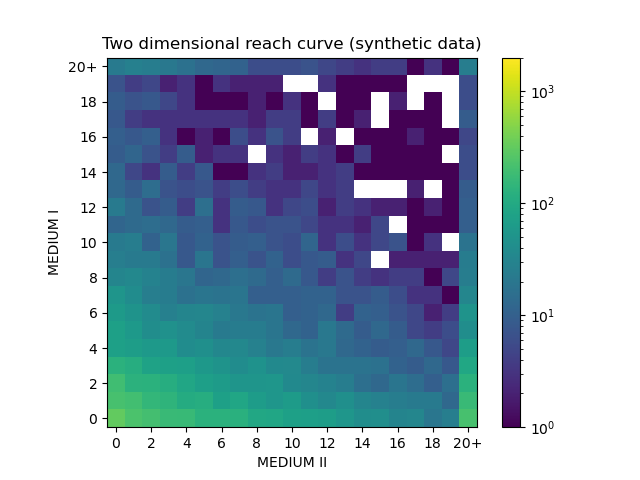

Text(0.5, 1.0, 'Two dimensional reach curve (synthetic data)')

In [4]:
report = generate_report(impressions, population_size=population_size, max_freq=20, id_col="user_id")

# Plot report
fig, ax = plt.subplots()
report.plot_2d_reach(media, ax=ax)
ax.set_title("Two dimensional reach curve (synthetic data)")

<IPython.core.display.Javascript object>


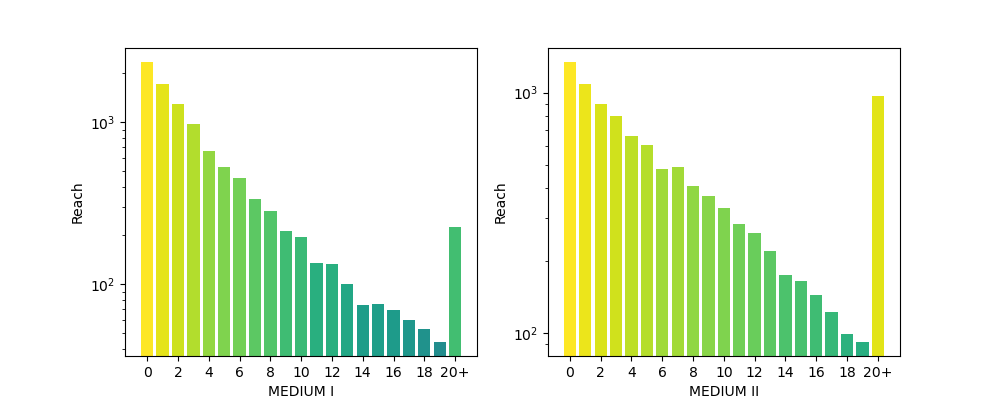

In [5]:
# Plot the one dimenaional reach frequency distribution for each medium

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for i, medium in enumerate(media) :
    report.plot_1d_reach(medium, ax=axs[i])

# Training the activity distribution function

We now  train the activity distribution function (ADF) from the cross measurement report. The ADF is a distribution that explains the exposure berhavior of society. The `ftrunc_reach` method can calculate (predict) the multidimensional reach curve from a given ADF. For a detailed description of how it works, look at the "mathematical foundations of VID modeling" page in the documentation.

Note that ADF prediction is a smooth function compared to the noisy reality (and later on the noisy virtual society report)

<IPython.core.display.Javascript object>


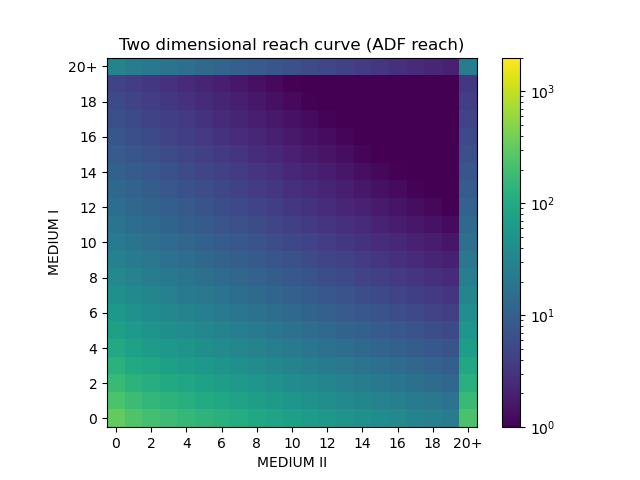

Text(0.5, 1.0, 'Two dimensional reach curve (ADF reach)')

In [6]:
adf = MixtureOfExponentials.random(n_exps=6, n_dims=2, rng=np.random.default_rng(1234))
adf.train(report)

# Plot the ADF generated reach surface
fig, ax = plt.subplots()
adf.plot_2d_reach(report.gr_values, dim_cols=media, max_freq=20,population_size=population_size,ax=ax)

ax.set_title("Two dimensional reach curve (ADF reach)")

In [7]:
adf.info()

,Amplitude,Type,dim=0,dim=1
0,0.587034,NormalExponentialADF,0.588233,0.971936
1,0.233186,NormalExponentialADF,1.638514,0.740807
2,0.026988,NormalExponentialADF,0.898338,6.390243
3,0.021838,NormalExponentialADF,2.382813,3.751288
4,0.107118,NormalExponentialADF,1.560430,0.702661
5,0.019163,NormalExponentialADF,0.502455,0.025176


## The normalization of the acitivity distribution (ADF)
The ADF, being a probability distribution should be normalized itself. Even more than that, since each individual activity is also proportional to the probability of exposure on the medium, should be normalized. This mean we expect the average of activities to be very close to `1.0`. The average of activities inidicates what portion of the impressions are recieved by the members. For a real society the average activity is exactly `1.0` as every impression has always had an exposed individual counterpart.

You should see that the ADF *and* the activities along all the dimensions are approximately normalized. You can refer to the documentation to learn more about why the normalization condition is not enforced directly during learning.

In [8]:
adf.normalization_info()

,Distribution,total_magnitude
0,ADF (sum of amplitudes),0.995327
1,Activities along dim d=0,0.980450
2,Activities along dim d=1,1.073434


# Generating the Virtual society

We know generate the vitual society from the ADF. To do so, we start from a uniform distribution of people and map that to the activity distribution that we learned from the data. To get a feel for how the virtual society works we plot the activity distribution of the virtual society as well as the orignal society in the next section.

In [9]:
virtual_society = adf.generate_virtual_society(
    population_size=population_size, 
    media_cols=media, 
    id_col="vid", 
    mode="uniform"
)


virtual_society.dataframe

,vid,MEDIUM I,MEDIUM II
0,0,0.008124,0.004773
1,1,0.008124,0.010040
2,2,0.008124,0.015850
3,3,0.008124,0.022245
4,4,0.008124,0.029246
...,...,...,...
9995,9995,6.368555,3.336682
9996,9996,6.368555,3.733610
9997,9997,6.368555,4.348285
9998,9998,6.368555,5.538113


## The multidimensional activity distribution of the society vs virtual society
Here we demonstrate at the activity distribution for a society compared to the activity distribution of the virtual society. It is obvious that while the two are following the same aggregate pattern, they are completely different societies. The most important point here is that while the activity of a normal society looks like a random distribution, we pick the virtual society to follow a specific uniform pattern that still follows the aggregate strucutre of the original society.

<IPython.core.display.Javascript object>


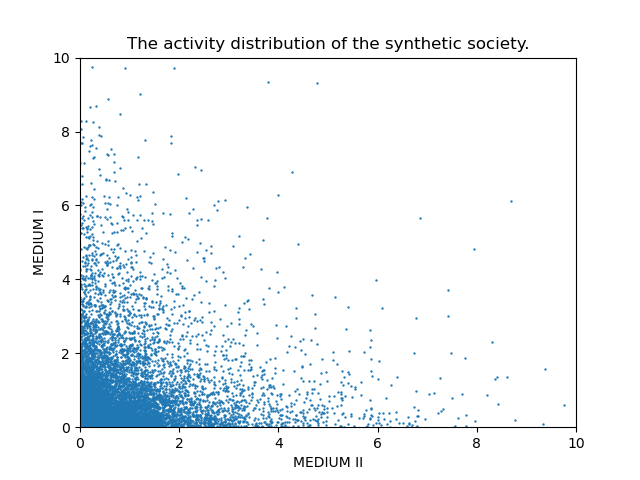

Text(0.5, 1.0, 'The activity distribution of the synthetic society.')

In [10]:
fig, ax = plt.subplots()
society.dataframe.plot(x='MEDIUM II', y='MEDIUM I', kind='scatter', style='o', s=0.5, ax=ax)
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_title("The activity distribution of the synthetic society.")

<IPython.core.display.Javascript object>


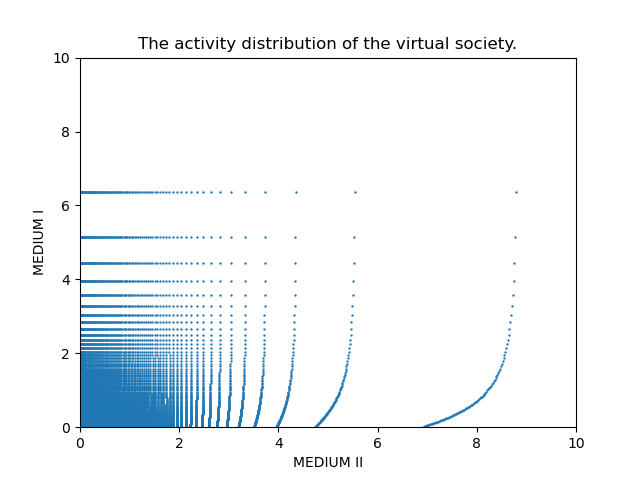

Text(0.5, 1.0, 'The activity distribution of the virtual society.')

In [11]:
fig, ax = plt.subplots()
virtual_society.dataframe.plot(x='MEDIUM II', y='MEDIUM I', kind='scatter', s=0.5, ax=ax)
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_title("The activity distribution of the virtual society.")

# Assign the impressions to the virtual members of the virtual society
The virtual society has the information about the users activity on each medium. Therefore, it can assign the impressions to the society (in the same fashion that we simulated the original campaign above). This mapping can be done using a random number generator or a deterministic hash function depending on the application and desired mapping methodology. Refer to the documentation to learn more about how mapping methodologies differ from each other.

You should see the impression logs below assigned to the `vid`s. We have kept the `user_id`s here for comparison purposes but for real applications, the original `user_id` column should be dropped.

In [12]:
vid_impressions = virtual_society.assign_impressions(impressions)

vid_impressions

,user_id,media,probability,vid
0,997,MEDIUM I,0.856174,9791
1,2572,MEDIUM I,0.289071,6962
2,7488,MEDIUM I,0.477966,8233
3,9664,MEDIUM I,0.535211,8669
4,6764,MEDIUM I,0.803868,9666
...,...,...,...,...
79995,2223,MEDIUM II,0.790255,9395
79996,6947,MEDIUM II,0.102575,7044
79997,4667,MEDIUM II,0.011129,3516
79998,1749,MEDIUM II,0.719299,6293


# Generate the VID report

We will now make a report from the vid impressions and plot it to see how the the measruement campares with the measurement of the original society ...

<IPython.core.display.Javascript object>


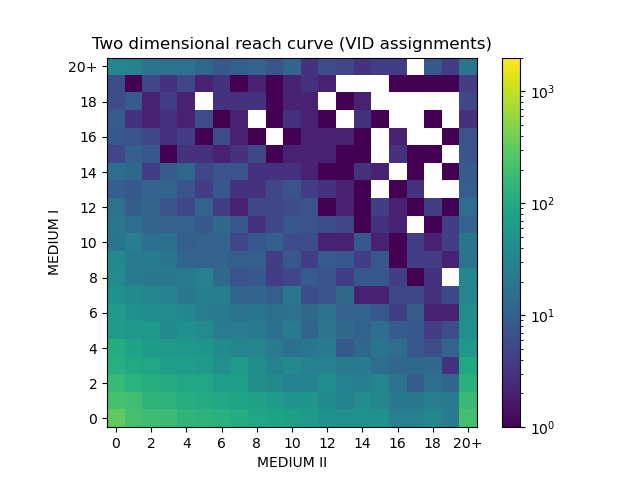

Text(0.5, 1.0, 'Two dimensional reach curve (VID assignments)')

In [13]:
vid_report = generate_report(impressions, population_size=population_size, max_freq=20, id_col="vid")

# plot the virtual ID assigned report
fig, ax = plt.subplots()
vid_report.plot_2d_reach(dims=media, ax=ax)
ax.set_title("Two dimensional reach curve (VID assignments)")

# Errors in the report generated by VID vs the original cross screen report
Below we inverstigate the multidimensional frequency reach surface error between the mneasurement report of the original society vs the report that was generated by the VID assigned to the impression table.

The first plot is the relative error between mutlidimensional reach over the range of 0 to 20+ frequencies. The error shows a noisey result specifically for higher frequencies. We also plot the error with a gaussian filter to show that the error is relatively small across the multi-frequency reach curve.

However, the important factors such as reach, overlap reach, and exclusive reach is shown to have a very reasonable accuracy, so the modelling correctly predicts the parameters of interest to ad campaign measurement.


In [14]:
report.compare_dims(vid_report)

(1, 1)


,Quantity,report_1,report_2,Relative percentage error
0,Total reach of all media,9675,9688,-0.13
1,Exclusive reach on MEDIUM I,1016,1022,-0.59
2,Exclusive reach on MEDIUM II,2028,1924,5.13
3,Overalp of MEDIUM I and MEDIUM II,6631,6742,-1.67


<IPython.core.display.Javascript object>


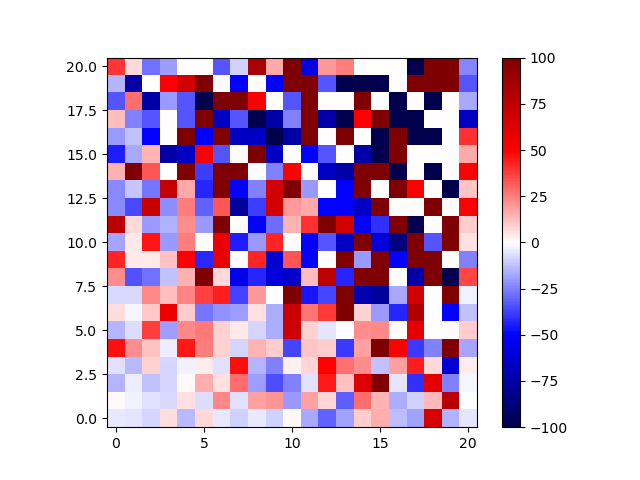

In [15]:
# Error across the multidimensional frequency domain
error = 100*(vid_report.pivot_to_dim_cols().values - report.pivot_to_dim_cols().values)/report.pivot_to_dim_cols().values

# clean up for the error matrix
error = np.nan_to_num(error, nan=0, posinf=100, neginf=-100)
error[error > 100] = 100
error[error < -100] = -100


fig, ax = plt.subplots()
im = ax.imshow(error,
           vmin=100,
           vmax=-100,
           cmap='seismic',
           origin="lower")
fig.colorbar(im, ax=ax)

<IPython.core.display.Javascript object>


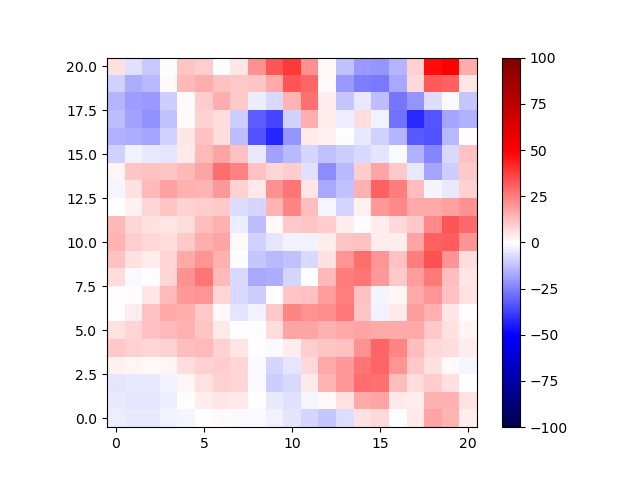

In [17]:
# Apply a gaussian filter with sigma of 1 to smooth out the multi-frequency curve
fig, ax = plt.subplots()
im = ax.imshow(gaussian_filter(error, 1),
           vmin=100,
           vmax=-100,
           cmap='seismic',
           origin="lower")
fig.colorbar(im, ax=ax)